In [23]:
import gdown
import zipfile
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import random
import cv2
import numpy as np


### **Carga del dataset**

In [2]:
url = "https://drive.google.com/uc?id=1QQKRENeBHR_Vj6az52N5sOx6ouSNKsuk"
output = "archivo.zip"

gdown.download(url, output, quiet=False, fuzzy=True)

destino = "datos_zip"
os.makedirs(destino, exist_ok=True)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(destino)

print("Archivo extraído correctamente en :", destino)

Downloading...
From (original): https://drive.google.com/uc?id=1QQKRENeBHR_Vj6az52N5sOx6ouSNKsuk
From (redirected): https://drive.google.com/uc?id=1QQKRENeBHR_Vj6az52N5sOx6ouSNKsuk&confirm=t&uuid=95fe912e-3d22-48de-8dba-1595a5d2d8d0
To: /content/archivo.zip
100%|██████████| 2.19G/2.19G [00:34<00:00, 62.9MB/s]


Archivo extraído correctamente en : datos_zip


Analizando las carpetas del dataset, podemos ver que tienen 3 carpetas: color, grayscale segmeted.

En cada carpeta, están separadas las imagenes en carpetas cuyo nombre se componen de la siguiente manera:

planta__enfermedad/healthy, esto último según se trate de imagenes de plantas sanas o tienen una enfermedad en particular.

In [3]:
data_dir = "datos_zip/plantvillage dataset"

# Existen 3 carpetas en el dataset
tipos = ["color", "grayscale", "segmented"]

all_data = []

for tipo in tipos:
    tipo_dir = os.path.join(data_dir, tipo)
    for label in os.listdir(tipo_dir):
        folder = os.path.join(tipo_dir, label)
        if os.path.isdir(folder):
            for img_name in os.listdir(folder):
                img_path = os.path.join(folder, img_name)
                # Se guarda el tipo (color, segmented,grayscale), el label (ej. Apple_Apple_scab) y el path a la imagen
                all_data.append({"tipo": tipo, "label": label, "path": img_path})


In [4]:
df = pd.DataFrame(all_data)
print(f"Total de imágenes: {len(df)}")
print(f"Número de clases: {df['label'].nunique()}")


Total de imágenes: 162916
Número de clases: 38


In [5]:
df.head()

tipo                                     label  \
0  color  Orange___Haunglongbing_(Citrus_greening)   
1  color  Orange___Haunglongbing_(Citrus_greening)   
2  color  Orange___Haunglongbing_(Citrus_greening)   
3  color  Orange___Haunglongbing_(Citrus_greening)   
4  color  Orange___Haunglongbing_(Citrus_greening)   

                                                path  
0  datos_zip/plantvillage dataset/color/Orange___...  
1  datos_zip/plantvillage dataset/color/Orange___...  
2  datos_zip/plantvillage dataset/color/Orange___...  
3  datos_zip/plantvillage dataset/color/Orange___...  
4  datos_zip/plantvillage dataset/color/Orange___...

Cada carpeta existen 38 clases.

In [6]:
df['tipo'].value_counts()

tipo
segmented    54306
color        54305
grayscale    54305
Name: count, dtype: int64

### **Revisamos si existen imágenes corruptas**

In [24]:
invalid = 0
for path in df['path']:
    try:
        with Image.open(path) as img:
            img.verify()  # verifica sin cargar toda la imagen
    except (UnidentifiedImageError, FileNotFoundError, OSError):
        invalid += 1

print(f"Imágenes corruptas: {invalid}")

Imágenes corruptas: 0


Separamos por tipo:

In [7]:
df_color = df[df['tipo'] == 'color']
df_gray = df[df['tipo'] == 'grayscale']
df_seg = df[df['tipo'] == 'segmented']

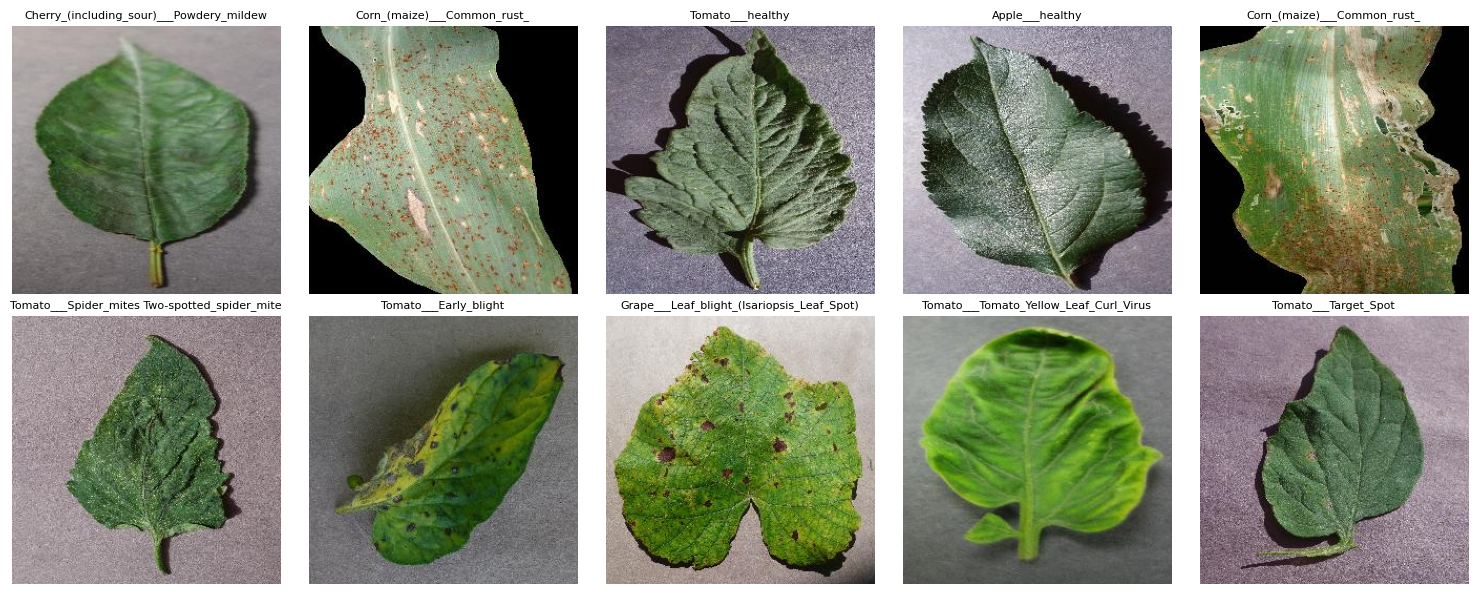

In [8]:
samples_color = df_color.sample(10, random_state=42)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, (_, row) in zip(axes.flatten(), samples_color.iterrows()):
    img = Image.open(row['path'])
    ax.imshow(img)
    ax.set_title(row['label'], fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

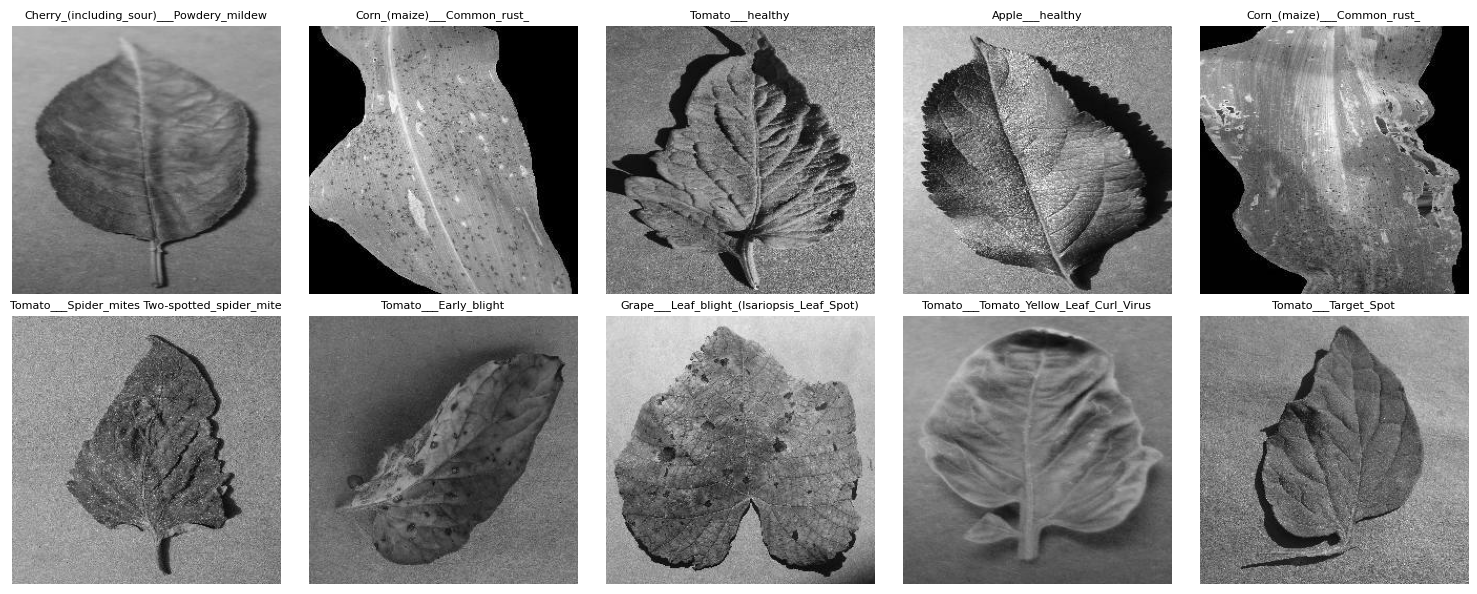

In [9]:
samples_gray = df_gray.sample(10, random_state=42)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, (_, row) in zip(axes.flatten(), samples_gray.iterrows()):
    img = Image.open(row['path'])
    ax.imshow(img)
    ax.set_title(row['label'], fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

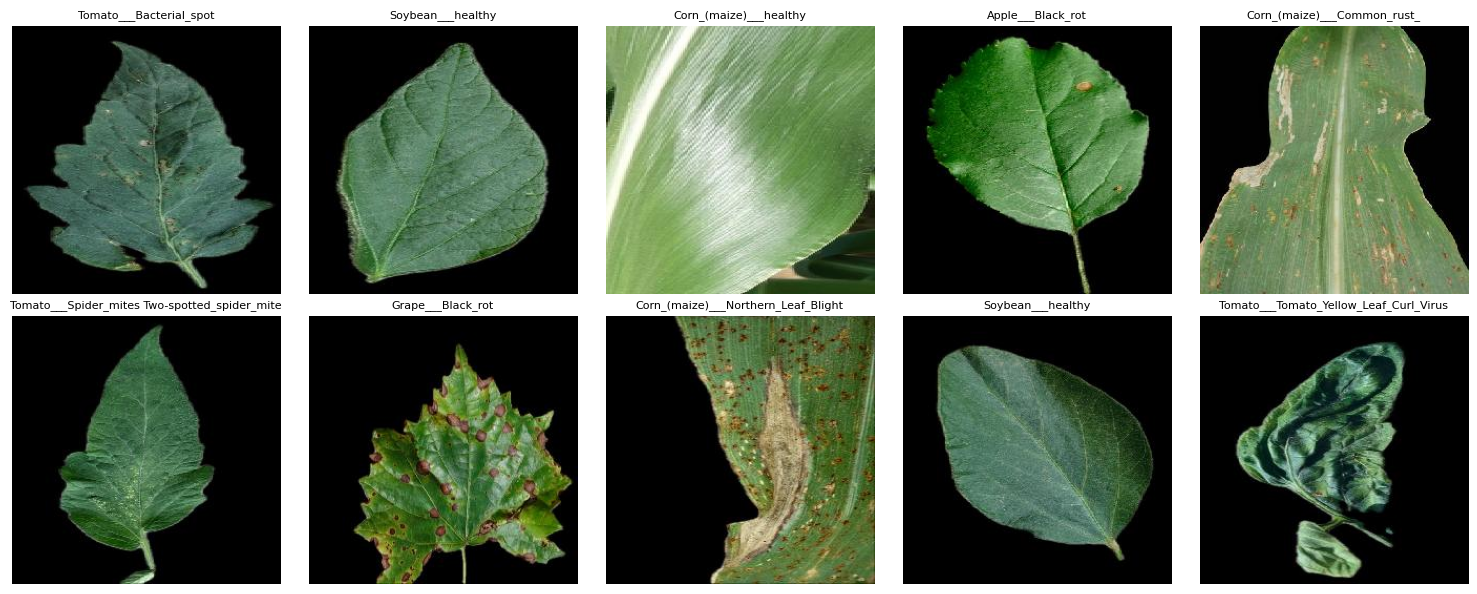

In [10]:
samples_seg = df_seg.sample(10, random_state=42)
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, (_, row) in zip(axes.flatten(), samples_seg.iterrows()):
    img = Image.open(row['path'])
    ax.imshow(img)
    ax.set_title(row['label'], fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

Como se pudo observar, en la carpeta color se encuentran las imagenes de las distintas plantas en color. En la carpeta grayscale, estan las mismas imagenes pero en estacala de grises y en la carpeta segmeted, son las mismas pero sin el fondo.

### **Distribución de categorías**

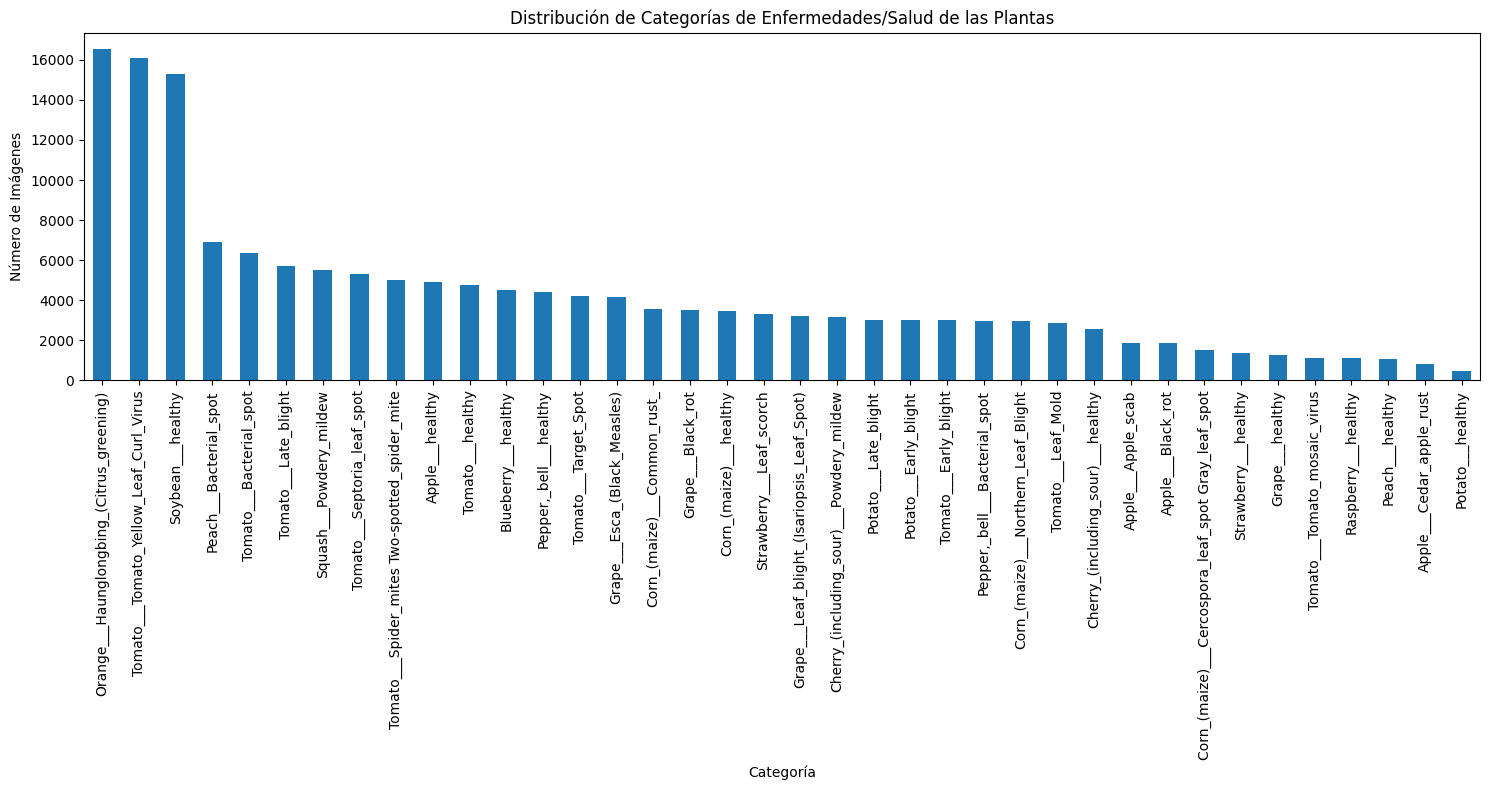

In [11]:
category_counts = df['label'].value_counts()

plt.figure(figsize=(15, 8))
category_counts.plot(kind='bar')
plt.title('Distribución de Categorías de Enfermedades/Salud de las Plantas')
plt.xlabel('Categoría')
plt.ylabel('Número de Imágenes')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Se puede observar que hay un sesgo hacía las enfermedades con mayor relevancia económica como la infección de cítricos llamada Huanglongbing (HLB) o "Greening" la cual no tiene cura o el "Curl Virus" del tomate. Esta información es importante para evaluar como afecta este desbalance de clases en el entrenamiento del modelo. Como varias enfermedades parecen presentar como síntoma la clorosis, amarillentamiento de la hoja, es sugestivo plantear un gráfico que compare la proporción entre amarillo y verde en cada clase.

In [12]:
def get_color_proportions(image_path):
    """
    Cálcula la proporción de píxeles verdes y amarillos en una imagen.
    """
    try:
        # Cargar imagen
        img = cv2.imread(image_path)
        if img is None:
            # Maneja la falla en la carga de una imagen
            return 0.0, 0.0

        # Cambiar el espacio de color de BGR a HSV
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Definimos un rango de amarillo
        # Es subjetivo pero puede refinarse si se encuentra útil la información
        lower_yellow = np.array([20, 100, 100])  # Hue, Saturation, Value
        upper_yellow = np.array([40, 255, 255])

        # Rangos para verde
        lower_green = np.array([40, 40, 40])
        upper_green = np.array([80, 255, 255])

        # Creamos la máscara para los dos colores
        mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
        mask_green = cv2.inRange(hsv, lower_green, upper_green)

        # Calculo el total de pixeles no-negros
        # obtamos por esta opción porque trabajemos sobre las imagenes segmentadas
        # Un pixel se considera no-negro cuando cuando la suma de los canales BGR no dan 0
        non_black_pixels_mask = (img[:,:,0] != 0) | (img[:,:,1] != 0) | (img[:,:,2] != 0)
        total_non_black_pixels = np.sum(non_black_pixels_mask)

        if total_non_black_pixels == 0:
            return 0.0, 0.0

        # Calculo el número de pixeles de cada color en la región no-negro
        yellow_pixels = np.sum(mask_yellow[non_black_pixels_mask] > 0)
        green_pixels = np.sum(mask_green[non_black_pixels_mask] > 0)

        # Calcúlo la proporción
        yellow_proportion = yellow_pixels / total_non_black_pixels
        green_proportion = green_pixels / total_non_black_pixels

        return yellow_proportion, green_proportion
    except Exception as e:
        print(f"Error procesando la imagen {image_path}: {e}")
        return 0.0, 0.0

In [13]:
print("Procesando imagenes para extraer proporción de verde y amarillo")

df_seg[['yellow_proportion', 'green_proportion']] = df_seg['path'].apply(lambda x: pd.Series(get_color_proportions(x)))

print("Proporción calculada")
df_seg.head()

Procesando imagenes para extraer proporción de verde y amarillo
Proporción calculada


/tmp/ipython-input-4168683580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seg[['yellow_proportion', 'green_proportion']] = df_seg['path'].apply(lambda x: pd.Series(get_color_proportions(x)))
/tmp/ipython-input-4168683580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seg[['yellow_proportion', 'green_proportion']] = df_seg['path'].apply(lambda x: pd.Series(get_color_proportions(x)))


tipo                                     label  \
108610  segmented  Orange___Haunglongbing_(Citrus_greening)   
108611  segmented  Orange___Haunglongbing_(Citrus_greening)   
108612  segmented  Orange___Haunglongbing_(Citrus_greening)   
108613  segmented  Orange___Haunglongbing_(Citrus_greening)   
108614  segmented  Orange___Haunglongbing_(Citrus_greening)   

                                                     path  yellow_proportion  \
108610  datos_zip/plantvillage dataset/segmented/Orang...           0.039468   
108611  datos_zip/plantvillage dataset/segmented/Orang...           0.000000   
108612  datos_zip/plantvillage dataset/segmented/Orang...           0.000249   
108613  datos_zip/plantvillage dataset/segmented/Orang...           0.409876   
108614  datos_zip/plantvillage dataset/segmented/Orang...           0.797076   

        green_proportion  
108610          0.823843  
108611          0.864270  
108612          0.852197  
108613          0.421319  
108614          0.080027

<Figure size 1800x900 with 0 Axes>

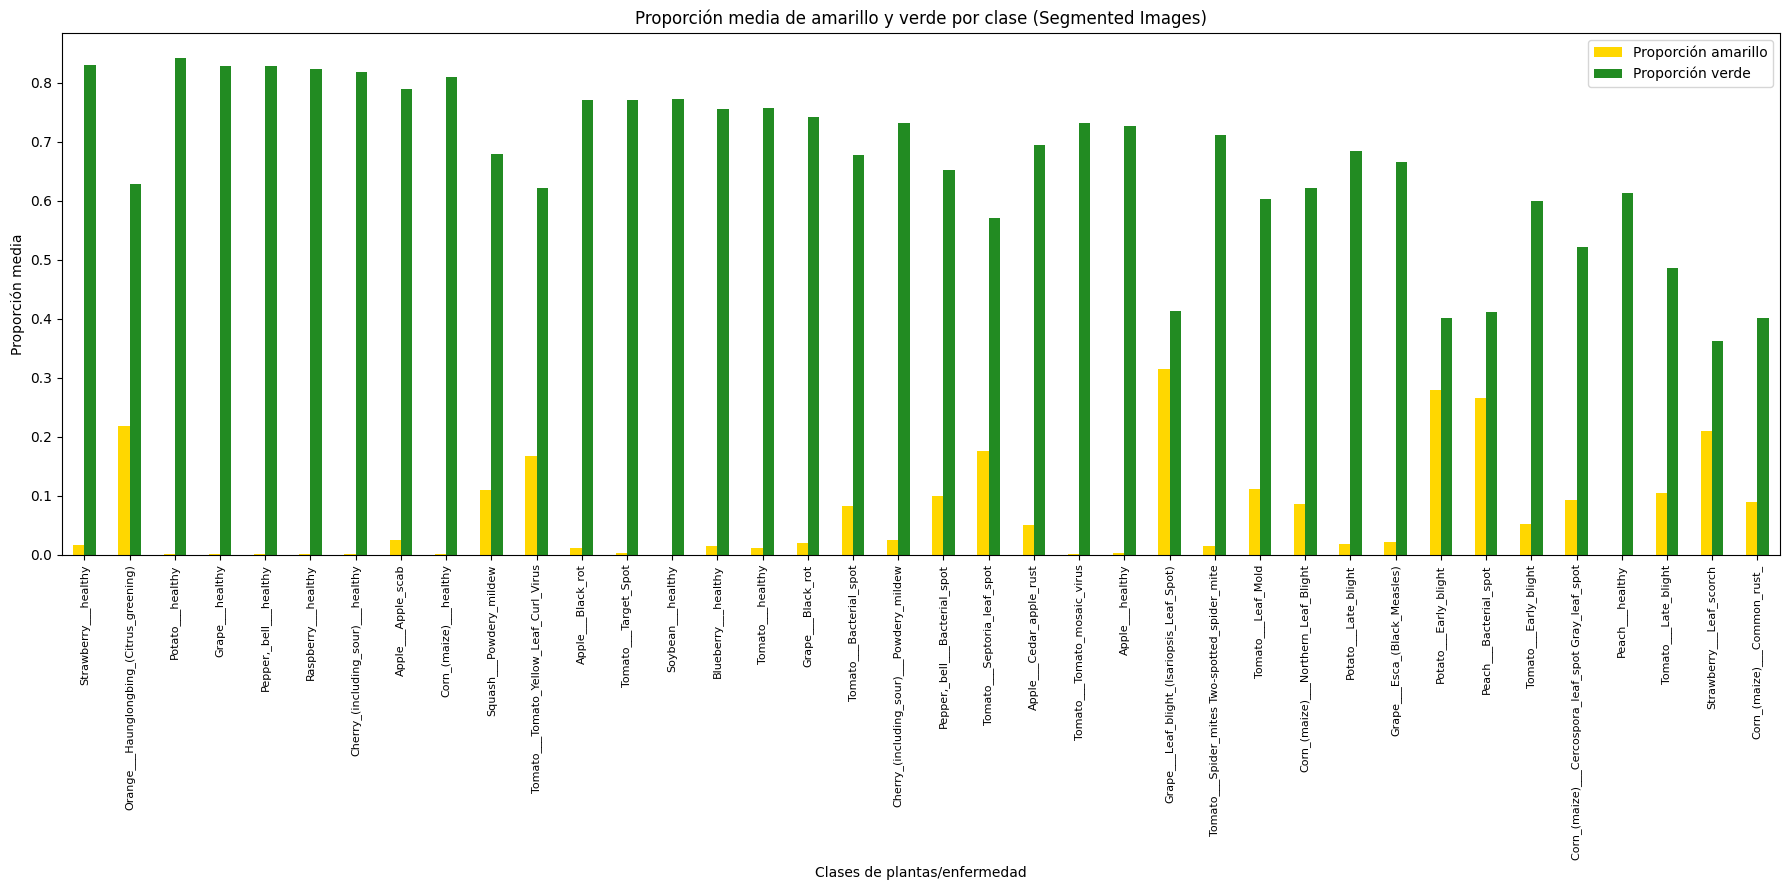

In [14]:
# Agrupamiento por label y cálculo de media por clase
mean_proportions = df_seg.groupby('label')[['yellow_proportion', 'green_proportion']].mean()

# Ordenar por propoción para facilitar la lectura
mean_proportions['total_proportion'] = mean_proportions['yellow_proportion'] + mean_proportions['green_proportion']
mean_proportions = mean_proportions.sort_values(by='total_proportion', ascending=False).drop(columns='total_proportion')

# Crear el gráfico de barras
plt.figure(figsize=(18, 9))
mean_proportions.plot(kind='bar', figsize=(18, 9), color={'yellow_proportion': 'gold', 'green_proportion': 'forestgreen'})
plt.title('Proporción media de amarillo y verde por clase (Segmented Images)')
plt.xlabel('Clases de plantas/enfermedad')
plt.ylabel('Proporción media')
plt.xticks(rotation=90, fontsize=8)
plt.legend(['Proporción amarillo', 'Proporción verde'])
plt.tight_layout()
plt.show()

Se puede apreciar como el el amarillo es caracteristico de algunas enfermedades como "Grape_lead_blight". Puede ser útil esta información al momento de entrenar el modelo

### **Análisis de tamaños de imágenes**

In [22]:
# Calculamos tamaño (ancho, alto) por cada imagen
sizes = []
for path in df['path']:
    try:
        with Image.open(path) as img:
            sizes.append(img.size)
    except:
        sizes.append((None, None))  # Por si alguna imagen falla

df_sizes = df.copy()
df_sizes[['width', 'height']] = pd.DataFrame(sizes, index=df_sizes.index)

# Agrupamos por tipo (color/grayscale/segmented) y resolución
res_by_type = (
    df_sizes
    .groupby(['tipo', 'width', 'height'])
    .size()
    .reset_index(name='count')
    .sort_values(['tipo', 'count'], ascending=[True, False])
)


#Resultados
print("Distribución de resoluciones por tipo de imagen:")
print(res_by_type.head(20))


print("\nNúmero de resoluciones distintas por tipo:")
print(res_by_type.groupby('tipo')['count'].count())



Distribución de resoluciones por tipo de imagen:
        tipo  width  height  count
0      color    256     256  54305
1  grayscale    256     256  54305
2  segmented    256     256  54302
3  segmented    324     512      1
4  segmented    335     512      1
5  segmented    466     512      1
6  segmented    470     512      1

Número de resoluciones distintas por tipo:
tipo
color        1
grayscale    1
segmented    5
Name: count, dtype: int64


La mayoría de las imágenes son del mismo tamaño. La que presenta imagenes de un tamaño diferente es la del tipo segmented, pero son solo 5. El resto tienen todas el mismo tamaño: 256x256